<a href="https://colab.research.google.com/github/atul-lanka/asl_recognition/blob/main/ASL_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#American Sign Language - Model Training

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet

from keras.layers import Flatten, Dense, Input, Dropout
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Nadam

import numpy as np
import argparse
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam
from datetime import datetime

##Dataset

In [ ]:
!unzip /content/drive/MyDrive/asl_alphabet.zip

In [4]:
training_data = '/content/asl_alphabet'

##Data Augmentation

In [5]:
IMAGE_SIZE = 200
BATCH_SIZE = 64

data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.75, 1.0],
    zoom_range=[1.0, 1.2], rescale=1./255,
    rotation_range=15.0,
    width_shift_range=0.15,
    height_shift_range=0.15,
    validation_split = 0.2
)

train_generator = data_generator.flow_from_directory(training_data, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(training_data, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 73265 images belonging to 39 classes.
Found 18312 images belonging to 39 classes.


## Inception V3 

In [15]:
inception_v3_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)

#Unfreezing specific layers to improve training
for layer in inception_v3_model.layers[:249]:
    layer.trainable = False
for layer in inception_v3_model.layers[249:]:
    layer.trainable = True

In [16]:
inception_output = inception_v3_model.output

In [17]:
x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(512, activation='relu')(x)
#x = layers.Dropout(0.2)(x)                  
x = layers.Dense(39, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5)

#Record time taken for model fitting
start=datetime.now()

history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch = 100,
    validation_steps=50,
    epochs=50, verbose =1,
    callbacks=[callback]
)

end=datetime.now()
print(end-start)

Epoch 1/50
100/100 [==============================] - 107s 1s/step - loss: 3.0636 - acc: 0.2362 - val_loss: 2.8022 - val_acc: 0.2309
Epoch 2/50
100/100 [==============================] - 105s 1s/step - loss: 1.8704 - acc: 0.5900 - val_loss: 2.0381 - val_acc: 0.4397
Epoch 3/50
100/100 [==============================] - 104s 1s/step - loss: 1.1542 - acc: 0.7317 - val_loss: 1.4938 - val_acc: 0.5931
Epoch 4/50
100/100 [==============================] - 104s 1s/step - loss: 0.8173 - acc: 0.7978 - val_loss: 1.2889 - val_acc: 0.6344
Epoch 5/50
100/100 [==============================] - 104s 1s/step - loss: 0.6311 - acc: 0.8433 - val_loss: 1.1027 - val_acc: 0.6884
Epoch 6/50
100/100 [==============================] - 103s 1s/step - loss: 0.4997 - acc: 0.8720 - val_loss: 0.9952 - val_acc: 0.7006
Epoch 7/50
100/100 [==============================] - 103s 1s/step - loss: 0.4234 - acc: 0.8869 - val_loss: 0.8685 - val_acc: 0.7450
Epoch 8/50
100/100 [==============================] - 103s 1s/step - 

##Plotting Results

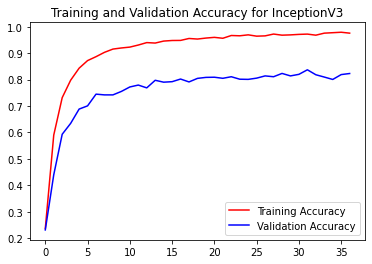

<Figure size 432x288 with 0 Axes>

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for InceptionV3')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

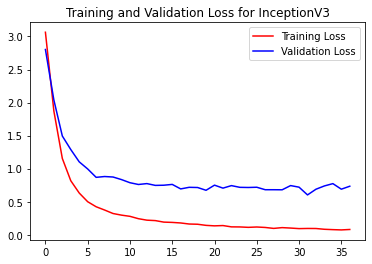

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss for InceptionV3')
plt.legend(loc=0)
plt.figure()

##Saving Model

In [21]:
MODEL_NAME = '/content/ASL_inceptionv3.h5'
model.save(MODEL_NAME)

## VGG-16

In [22]:
vgg16_model = VGG16(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)

for layer in vgg16_model.layers[:11]:
    layer.trainable = False
for layer in vgg16_model.layers[11:]:
    layer.trainable = True

58892288/58889256 [==============================] - 0s 0us/step


In [23]:
vgg_output = vgg16_model.output

In [24]:
x1 = layers.GlobalAveragePooling2D()(vgg_output)
x1 = layers.Dense(512, activation='relu')(x1)
x1 = layers.Dropout(0.2)(x1)                  
x1 = layers.Dense(39, activation='softmax')(x1)           

model1 = Model(vgg16_model.input, x1) 

model1.compile(
    optimizer=SGD(lr=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5)

start=datetime.now()

history = model1.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch = 100,
    validation_steps=50,
    epochs=50, verbose =1,
    callbacks=[callback])

end=datetime.now()
print(end-start)

Epoch 1/50
100/100 [==============================] - 118s 1s/step - loss: 3.1529 - acc: 0.1567 - val_loss: 1.8759 - val_acc: 0.5019
Epoch 2/50
100/100 [==============================] - 115s 1s/step - loss: 0.8925 - acc: 0.7391 - val_loss: 0.5718 - val_acc: 0.8537
Epoch 3/50
100/100 [==============================] - 117s 1s/step - loss: 0.3494 - acc: 0.8947 - val_loss: 0.3109 - val_acc: 0.9169
Epoch 4/50
100/100 [==============================] - 115s 1s/step - loss: 0.2409 - acc: 0.9277 - val_loss: 0.2672 - val_acc: 0.9181
Epoch 5/50
100/100 [==============================] - 115s 1s/step - loss: 0.1944 - acc: 0.9411 - val_loss: 0.2589 - val_acc: 0.9278
Epoch 6/50
100/100 [==============================] - 115s 1s/step - loss: 0.1142 - acc: 0.9666 - val_loss: 0.2995 - val_acc: 0.9022
Epoch 7/50
100/100 [==============================] - 115s 1s/step - loss: 0.1023 - acc: 0.9722 - val_loss: 0.1970 - val_acc: 0.9394
Epoch 8/50
100/100 [==============================] - 116s 1s/step - 

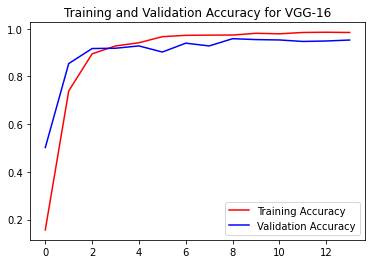

<Figure size 432x288 with 0 Axes>

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for VGG-16')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

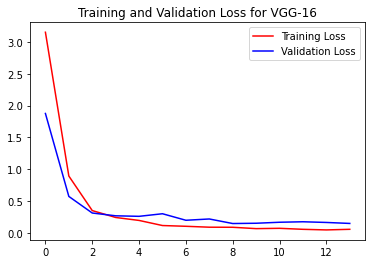

<Figure size 432x288 with 0 Axes>

In [27]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss for VGG-16')
plt.legend(loc=0)
plt.figure()

In [28]:
MODEL_NAME = '/content/ASL_vgg16.h5'
model1.save(MODEL_NAME)

## ResNet-50

In [29]:
resnet50_model = ResNet50(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)

for layer in resnet50_model.layers[:-98]:
    layer.trainable = False
for layer in resnet50_model.layers[-98:]:
    layer.trainable = True

94773248/94765736 [==============================] - 1s 0us/step


In [30]:
resnet50_output = resnet50_model.output

In [31]:
x2 = layers.GlobalAveragePooling2D()(resnet50_output)
x2 = layers.Dense(512, activation='relu')(x2)
x2 = layers.Dropout(0.2)(x2)                  
x2 = layers.Dense(39, activation='softmax')(x2)           

model2 = Model(resnet50_model.input, x2) 

model2.compile(
    optimizer=SGD(lr=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5)

start=datetime.now()

history = model2.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch = 100,
    validation_steps=50,
    epochs=50, verbose =1,
    callbacks=[callback])

end=datetime.now()
print(end-start)

Epoch 1/50
100/100 [==============================] - 117s 1s/step - loss: 2.8667 - acc: 0.2583 - val_loss: 3.0429 - val_acc: 0.1669
Epoch 2/50
100/100 [==============================] - 118s 1s/step - loss: 1.2314 - acc: 0.6758 - val_loss: 1.8777 - val_acc: 0.4556
Epoch 3/50
100/100 [==============================] - 117s 1s/step - loss: 0.6421 - acc: 0.8197 - val_loss: 1.1354 - val_acc: 0.6891
Epoch 4/50
100/100 [==============================] - 116s 1s/step - loss: 0.4315 - acc: 0.8736 - val_loss: 0.8826 - val_acc: 0.7394
Epoch 5/50
100/100 [==============================] - 117s 1s/step - loss: 0.3099 - acc: 0.9087 - val_loss: 0.6979 - val_acc: 0.7866
Epoch 6/50
100/100 [==============================] - 116s 1s/step - loss: 0.2520 - acc: 0.9280 - val_loss: 0.6801 - val_acc: 0.7944
Epoch 7/50
100/100 [==============================] - 116s 1s/step - loss: 0.1979 - acc: 0.9409 - val_loss: 0.6803 - val_acc: 0.8222
Epoch 8/50
100/100 [==============================] - 116s 1s/step - 

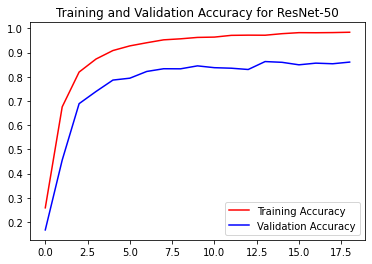

<Figure size 432x288 with 0 Axes>

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for ResNet-50')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

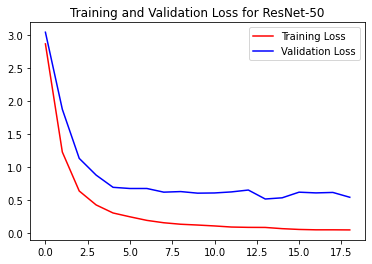

<Figure size 432x288 with 0 Axes>

In [34]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss for ResNet-50')
plt.legend(loc=0)
plt.figure()

In [35]:
MODEL_NAME = '/content/ASL_resnet50.h5'
model2.save(MODEL_NAME)